In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import sys

from aux import get_seg
from disp import set_font_size, get_line
from time_stats import xcov_multi_with_confidence

cc = np.concatenate

SONG_FILE = 'data/simple/c_songs.npy'
COLORS = [(.7, .7, .7), 'b', 'r', (1, .5, 0)]

In [2]:
tmp = np.load(SONG_FILE, allow_pickle=True)[0]
songs = tmp['songs']
dt = tmp['dt']
fps = tmp['fps']

In [3]:
durs = dt*np.array([len(s) for s in songs])
m_cpln = ~(durs == durs.max())

In [4]:
def plot_s(ax, t, s, extent, c, t_bar=1):
    """
    Note: extent: [x_min, x_max, y_min, y_max]
    """
    x_0 = extent[0]
    dx = (extent[1] - extent[0]) / len(s)
    modes = range(4)
    for mode in modes:
        bds = get_seg(s==mode, min_gap=1)[1]
        for istart, iend in bds:
            ax.fill_between([x_0+dx*istart, x_0+dx*iend], 2*[extent[2]], 2*[extent[3]], color=c[mode])
            
    dt = np.mean(np.gradient(t))
    dy_scale = .2*(extent[3]-extent[2])
    ax.fill_between([x_0, x_0+dx/dt*t_bar], 2*[extent[3] + 2*dy_scale], 2*[extent[3] + 3*dy_scale], color='k')
    return ax

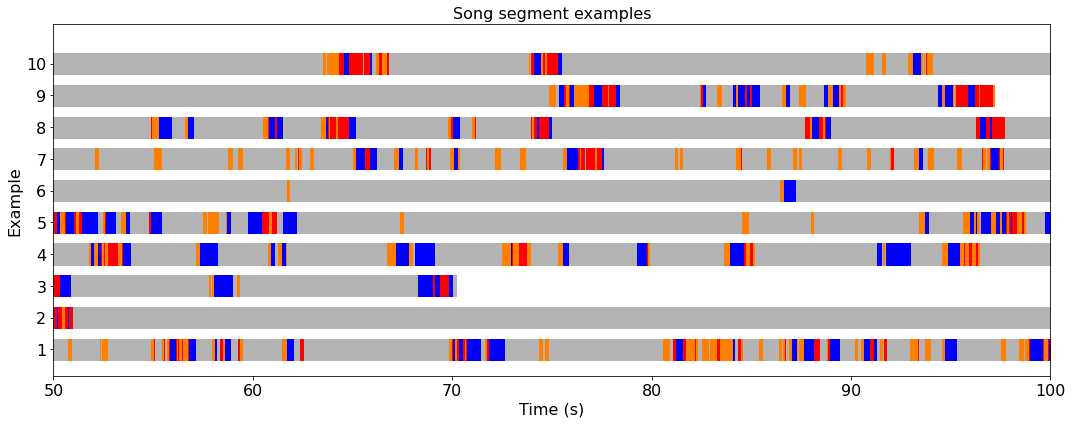

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(15, 6), tight_layout=True)

y_ticks = []
for cs, isong in enumerate(range(10)):
    s = songs[isong]
    t = np.arange(len(s))*dt
    plot_s(ax, t, s, extent=[0, len(s)*dt, 1.5*cs, 1.5*cs+1], c=COLORS, t_bar=0)
    y_ticks.append(1.5*cs + .5)

ax.set_xlim(50, 100)
ax.set_yticks(y_ticks)
ax.set_yticklabels(np.arange(len(y_ticks))+1)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Example')
ax.set_title('Song segment examples')

set_font_size(ax, 16)

Time till copulation distribution

In [6]:
def plot_hists(x, bins=30, c='k', lw=3, fig=None, axs=None, **kwargs):
    if fig is None and axs is None:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)
    cts, bins = np.histogram(x, bins=bins, **kwargs)
    binc = .5*(bins[:-1] + bins[1:])
    axs[0].plot(binc, cts, c=c, lw=lw)
    axs[1].semilogy(binc, cts, c=c, lw=lw)
    axs[2].loglog(binc, cts, c=c, lw=lw)
    
    return fig, axs

Text(11, 17.5, 'Std = 5.25 min')

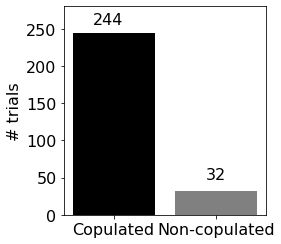

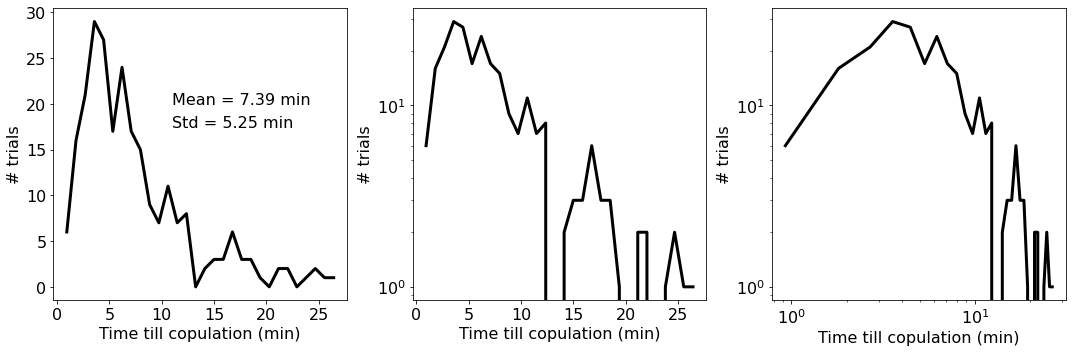

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3.5), tight_layout=True)
n = len(songs)
n_cpln = m_cpln.sum()

ax.bar([0, 1], [n_cpln, n-n_cpln], color=['k', 'gray'], align='center')
ax.set_ylim(0, 280)
ax.set_xticks([0, 1])
ax.set_xticklabels(['Copulated', 'Non-copulated'])
ax.set_ylabel('# trials')
ax.text(-.2, 256, f'{n_cpln}', fontsize=16)
ax.text(.9, 48, f'{n-n_cpln}', fontsize=16)

set_font_size(ax, 16)

t_cpln = durs[durs < durs.max()]

fig, axs = plot_hists(t_cpln/60, bins=30)
for ax in axs:
    ax.set_xlabel('Time till copulation (min)')
    ax.set_ylabel('# trials')
    set_font_size(ax, 16)
axs[0].text(11, 20, f'Mean = {t_cpln.mean()/60:.2f} min', fontsize=16)
axs[0].text(11, 17.5, f'Std = {t_cpln.std()/60:.2f} min', fontsize=16)

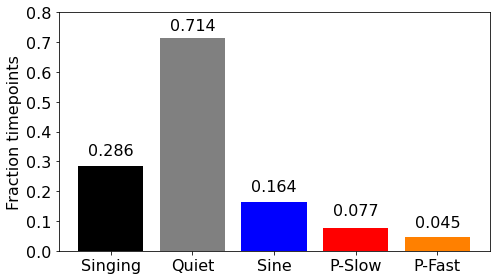

In [8]:
songs_cc = cc(songs)
frc_sng = np.mean(songs_cc > 0)
frc_qui = np.mean(songs_cc == 0)
frc_sin = np.mean(songs_cc == 1)
frc_psl = np.mean(songs_cc == 2)
frc_pfs = np.mean(songs_cc == 3)

fig, ax = plt.subplots(1, 1, figsize=(7, 4), tight_layout=True)
ax.bar(range(5), [frc_sng, frc_qui, frc_sin, frc_psl, frc_pfs], color=['k', 'gray', 'b', 'r', (1, .5, 0)], align='center')
ax.set_ylim(0, .8)
ax.set_xticks(range(5))
ax.set_xticklabels(['Singing', 'Quiet', 'Sine', 'P-Slow', 'P-Fast'])
ax.set_ylabel('Fraction timepoints')
ax.text(0, .32, f'{frc_sng:.3f}', ha='center', fontsize=16)
ax.text(1, .74, f'{frc_qui:.3f}', ha='center', fontsize=16)
ax.text(2, .2, f'{frc_sin:.3f}', ha='center', fontsize=16)
ax.text(3, .12, f'{frc_psl:.3f}', ha='center', fontsize=16)
ax.text(4, .08, f'{frc_pfs:.3f}', ha='center', fontsize=16)
set_font_size(ax, 16)

Text(3, 5000, 'Std = 0.098 s')

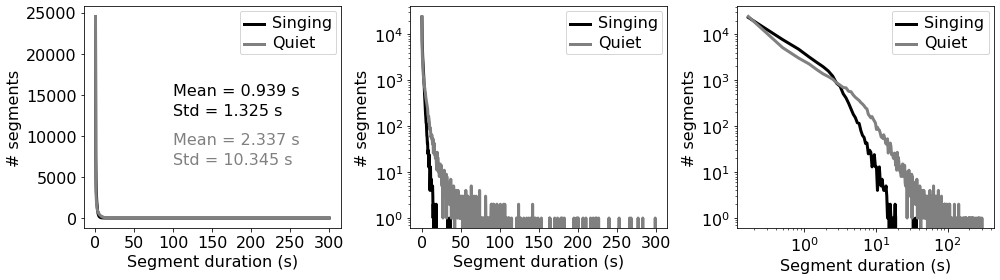

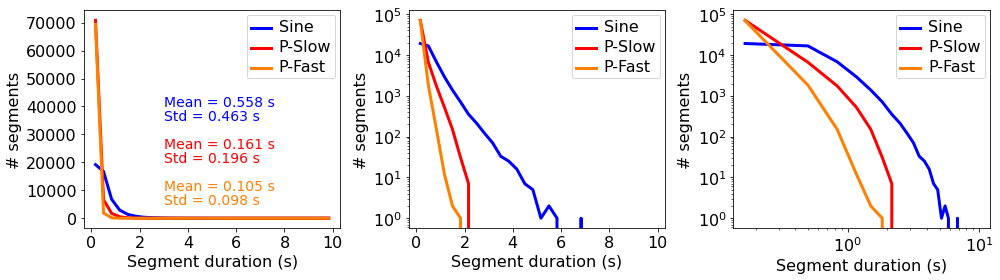

In [9]:
durs_sng = []
durs_qui = []
durs_sin = []
durs_psl = []
durs_pfs = []

for s in songs:
    bds_sng = get_seg(s > 0, min_gap=1)[1]*dt
    durs_sng.extend(bds_sng[:, 1] - bds_sng[:, 0])
    
    bds_qui = get_seg(s == 0, min_gap=1)[1]*dt
    durs_qui.extend(bds_qui[:, 1] - bds_qui[:, 0])
    
    bds_sin = get_seg(s == 1, min_gap=1)[1]*dt
    durs_sin.extend(bds_sin[:, 1] - bds_sin[:, 0])
    
    bds_psl = get_seg(s == 2, min_gap=1)[1]*dt
    durs_psl.extend(bds_psl[:, 1] - bds_psl[:, 0])
    
    bds_pfs = get_seg(s == 3, min_gap=1)[1]*dt
    durs_pfs.extend(bds_pfs[:, 1] - bds_pfs[:, 0])
    
durs_sng = np.array(durs_sng)
durs_qui = np.array(durs_qui)
durs_sin = np.array(durs_sin)
durs_psl = np.array(durs_psl)
durs_pfs = np.array(durs_pfs)

fig, axs = plt.subplots(1, 3, figsize=(14, 4), tight_layout=True)
bins = np.linspace(0, 300, 901)
plot_hists(durs_sng, bins=bins, c='k', lw=3, fig=fig, axs=axs)
plot_hists(durs_qui, bins=bins, c='gray', lw=3, fig=fig, axs=axs)

for ax in axs:
    ax.set_xlabel('Segment duration (s)')
    ax.set_ylabel('# segments')
    ax.legend(['Singing', 'Quiet'])
set_font_size(axs, 16)

axs[0].text(100, 15000, f'Mean = {durs_sng.mean():.3f} s', color='k', fontsize=16)
axs[0].text(100, 12500, f'Std = {durs_sng.std():.3f} s', color='k', fontsize=16)
axs[0].text(100, 9000, f'Mean = {durs_qui.mean():.3f} s', color='gray', fontsize=16)
axs[0].text(100, 6500, f'Std = {durs_qui.std():.3f} s', color='gray', fontsize=16)

fig, axs = plt.subplots(1, 3, figsize=(14, 4), tight_layout=True)
bins = np.linspace(0, 10, 31)
plot_hists(durs_sin, bins=bins, c='b', lw=3, fig=fig, axs=axs)
plot_hists(durs_psl, bins=bins, c='r', lw=3, fig=fig, axs=axs)
plot_hists(durs_pfs, bins=bins, c=(1, .5, 0), lw=3, fig=fig, axs=axs)

for ax in axs:
    ax.set_xlabel('Segment duration (s)')
    ax.set_ylabel('# segments')
    ax.legend(['Sine', 'P-Slow', 'P-Fast'])
set_font_size(axs, 16)

axs[0].text(3, 40000, f'Mean = {durs_sin.mean():.3f} s', color='b', fontsize=14)
axs[0].text(3, 35000, f'Std = {durs_sin.std():.3f} s', color='b', fontsize=14)
axs[0].text(3, 25000, f'Mean = {durs_psl.mean():.3f} s', color='r', fontsize=14)
axs[0].text(3, 20000, f'Std = {durs_psl.std():.3f} s', color='r', fontsize=14)
axs[0].text(3, 10000, f'Mean = {durs_pfs.mean():.3f} s', color=(1, .5, 0), fontsize=14)
axs[0].text(3, 5000, f'Std = {durs_pfs.std():.3f} s', color=(1, .5, 0), fontsize=14)

Transition probabilities

In [10]:
# timepoint-wise transitions
tr_ct_mat = np.zeros((4, 4))

for s in songs:
    for mode_from in range(4):
        for mode_to in range(4):
            tr_ct_mat[mode_from, mode_to] += np.sum((s[:-1] == mode_from)&(s[1:] == mode_to))
    
tr_p_mat = tr_ct_mat.copy()
for cr in range(4):
    tr_p_mat[cr] /= tr_p_mat[cr].sum()
    
# segment transition probabilities
## segments sequences
songs_seg = []
for s in songs:
    tmp = s.astype(float)
    tmp[1:][np.diff(tmp) == 0] = np.nan
    songs_seg.append(tmp[~np.isnan(tmp)].astype(int))

## probabilities
seg_tr_ct_mat = np.zeros((4, 4))

for s_seg in songs_seg:
    for mode_from in range(4):
        for mode_to in range(4):
            seg_tr_ct_mat[mode_from, mode_to] += np.sum((s_seg[:-1] == mode_from)&(s_seg[1:] == mode_to))
                
seg_tr_p_mat = seg_tr_ct_mat.copy()
for cr in range(4):
    seg_tr_p_mat[cr] /= np.sum(seg_tr_p_mat[cr])

Timepoint transitions
[[0.98579774 0.00363454 0.00459549 0.00597223]
 [0.02116652 0.94034265 0.02823062 0.01026021]
 [0.03702704 0.06180258 0.79262522 0.10854516]
 [0.08420931 0.05308925 0.18118341 0.68151803]]
Segment transitions
[[0.         0.25591253 0.32357485 0.42051262]
 [0.35480152 0.         0.47321282 0.17198567]
 [0.17855131 0.29802361 0.         0.52342508]
 [0.26440839 0.16669468 0.56889692 0.        ]]


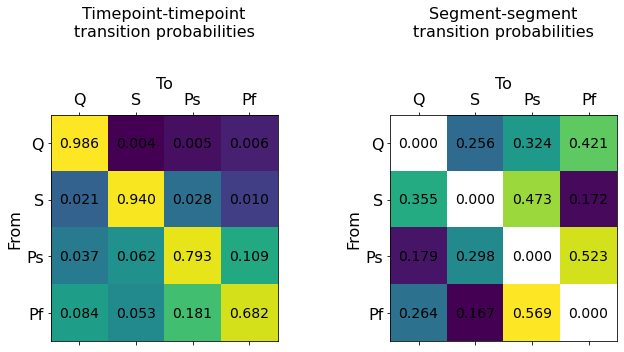

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5), tight_layout=True)
axs[0].matshow(np.log(tr_p_mat))
axs[0].set_title('Timepoint-timepoint\ntransition probabilities\n\n')
axs[1].matshow(np.log(seg_tr_p_mat))
axs[1].set_title('Segment-segment\ntransition probabilities\n\n')

for ax in axs:
    ax.set_xticks(range(4))
    ax.set_yticks(range(4))
    ax.set_xlim(-.5, 3.5)
    ax.set_ylim(3.5, -.5)
    ax.set_xticklabels(['Q', 'S', 'Ps', 'Pf'])
    ax.set_yticklabels(['Q', 'S', 'Ps', 'Pf'])
    ax.set_xlabel('To')
    ax.set_ylabel('From')
    ax.xaxis.set_label_position('top')

set_font_size(axs, 16)

print('Timepoint transitions')
print(tr_p_mat)

print('Segment transitions')
print(seg_tr_p_mat)

for mode_from in range(4):
    for mode_to in range(4):
        axs[0].text(mode_to, mode_from, f'{tr_p_mat[mode_from, mode_to]:.3f}', ha='center', va='center', fontsize=14)
        axs[1].text(mode_to, mode_from, f'{seg_tr_p_mat[mode_from, mode_to]:.3f}', ha='center', va='center', fontsize=14)

## Autocovariances

$$C_i(\Delta t) = \frac{1}{T_i(\Delta t)-1} \sum_{t=1}^{T_i(\Delta t)} [(x_i(t) - \mu_{x_i(t)})(x_i(t+\Delta t) - \mu_{x_i(t+\Delta t)})]$$

$$C_i^*(\Delta t) = C_i(\Delta t) / C_i(0)$$

$$\textrm{Autocovariance}(\Delta t) = \sum_i C_i^*(\Delta t)\frac{T_i}{\sum_i T_i}$$

Aggregated songs

In [12]:
lag_bak = int(round(30*fps))
lag_fwd = int(round(30*fps))

# two-point correlation func for singing vs non-singing
s_bnry = [(s > 0).astype(float) for s in songs]
cov_sng, _, _, _ = xcov_multi_with_confidence(s_bnry, s_bnry, lag_backward=lag_bak, lag_forward=lag_fwd, pre_norm=False, scale=True)

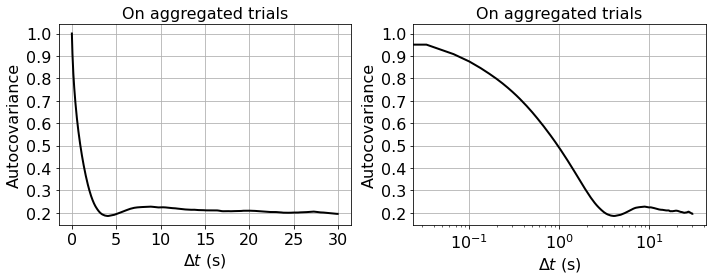

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
t_cov = np.arange(-lag_bak, lag_fwd) * dt

axs[0].plot(t_cov[t_cov >= 0], cov_sng[t_cov >= 0], lw=2, c='k')
axs[1].semilogx(t_cov[t_cov >= 0], cov_sng[t_cov >= 0], lw=2, c='k')

for ax in axs:
    ax.set_xlabel('$\Delta t$ (s)')
    ax.set_ylabel('Autocovariance')
    ax.set_title('On aggregated trials')
    ax.grid()
    
set_font_size(axs, 16)

In [14]:
labels = ['Quiet', 'Sine', 'P-Slow', 'P-Fast']

# two-point correlation function for each mode
covs = []
p_vals = []
lbs = []
ubs = []

for mode in [0, 1, 2, 3]:
    print(f'Computing auto-corr for {labels[mode]} mode')
    s_bnry = [(s == mode).astype(float) for s in songs]
    cov, p_val, lb, ub = xcov_multi_with_confidence(
        s_bnry, s_bnry, lag_backward=lag_bak, lag_forward=lag_fwd, pre_norm=False, scale=True)
    
    covs.append(cov)
    p_vals.append(p_val)
    lbs.append(lb)
    ubs.append(ub)

Computing auto-corr for Quiet mode
Computing auto-corr for Sine mode
Computing auto-corr for P-Slow mode
Computing auto-corr for P-Fast mode


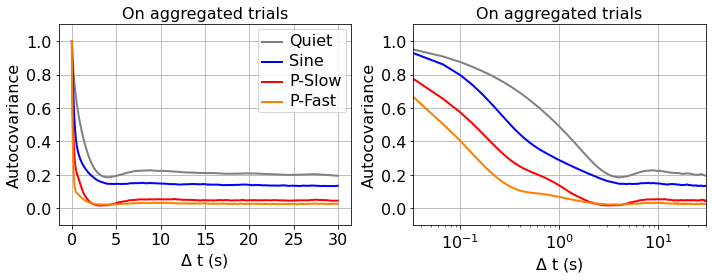

In [15]:
colors = ['gray', 'b', 'r', (1, .5, 0)]
t_cov = np.arange(-lag_bak, lag_fwd) * dt

fig, axs = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

for mode in [0, 1, 2, 3]:
    axs[0].plot(t_cov[t_cov >= 0], covs[mode][t_cov >= 0], lw=2, c=colors[mode])
    axs[1].semilogx(t_cov[t_cov > 0], covs[mode][t_cov > 0], lw=2, c=colors[mode])

axs[0].legend(labels)
axs[1].set_xlim(dt, lag_fwd*dt)
  
for ax in axs:
    ax.grid()
    ax.set_ylim(-.1, 1.1)
    ax.set_xlabel(r'$\Delta$ t (s)')
    ax.set_ylabel('Autocovariance')
    ax.set_title('On aggregated trials')
    
    set_font_size(ax, 16)

Averaged across songs

In [16]:
# singing vs non-singing
covs_sng = []
for s in songs:
    sys.stdout.write('.')
    s_bnry = [(s > 0).astype(float)]
    cov_sng, _, _, _ = xcov_multi_with_confidence(s_bnry, s_bnry, lag_backward=lag_bak, lag_forward=lag_fwd, pre_norm=False, scale=True)
    covs_sng.append(cov_sng)

....................................................................................................................................................................................................................................................................................

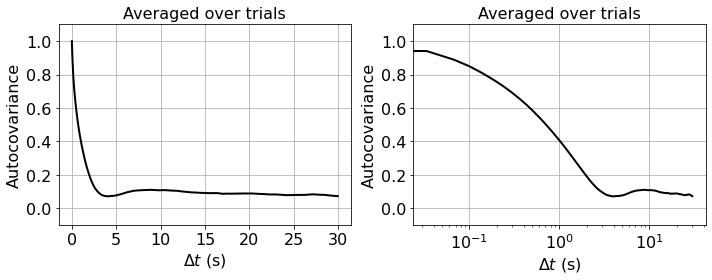

In [17]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)
covs_sng = np.array(covs_sng)

dur_mat = np.tile(durs[:, None], (1, covs_sng.shape[1]))
dur_mat[np.isnan(covs_sng)] = np.nan
weight_mat = dur_mat / np.nansum(dur_mat, 0)

covs_sng_mean = np.nansum(covs_sng*weight_mat, axis=0)

t_cov = np.arange(-lag_bak, lag_fwd) * dt

axs[0].plot(t_cov[t_cov >= 0], covs_sng_mean[t_cov >= 0], lw=2, c='k')
axs[1].semilogx(t_cov[t_cov >= 0], covs_sng_mean[t_cov >= 0], lw=2, c='k')

for ax in axs:
    ax.set_ylim(-.1, 1.1)
    ax.set_xlabel('$\Delta t$ (s)')
    ax.set_ylabel('Autocovariance')
    ax.set_title('Averaged over trials')
    ax.grid()
    
set_font_size(axs, 16)

In [18]:
# for each mode
covs = [[], [], [], []]

for s in songs:
    sys.stdout.write('.')
    for mode in range(4):
        s_bnry = [(s == mode).astype(float)]
        cov, _, _, _ = xcov_multi_with_confidence(
            s_bnry, s_bnry, lag_backward=lag_bak, lag_forward=lag_fwd, pre_norm=False, scale=True)
        
        covs[mode].append(cov)
        
cov_means = [np.nansum(weight_mat * np.array(covs_), axis=0) for covs_ in covs]

....................................................................................................................................................................................................................................................................................

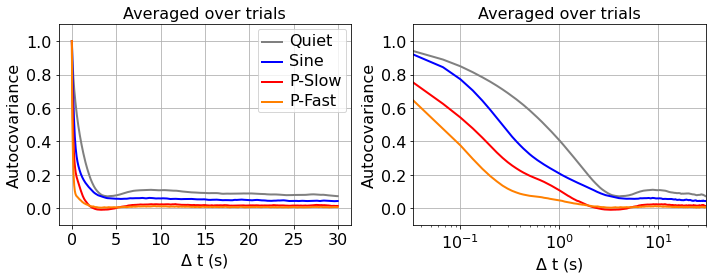

In [19]:
colors = ['gray', 'b', 'r', (1, .5, 0)]
t_cov = np.arange(-lag_bak, lag_fwd) * dt

fig, axs = plt.subplots(1, 2, figsize=(10, 4), tight_layout=True)

for mode in [0, 1, 2, 3]:
    axs[0].plot(t_cov[t_cov >= 0], cov_means[mode][t_cov >= 0], lw=2, c=colors[mode])
    axs[1].semilogx(t_cov[t_cov > 0], cov_means[mode][t_cov > 0], lw=2, c=colors[mode])

axs[0].legend(labels)
axs[1].set_xlim(dt, lag_fwd*dt)
  
for ax in axs:
    ax.grid()
    ax.set_ylim(-.1, 1.1)
    ax.set_xlabel(r'$\Delta$ t (s)')
    ax.set_ylabel('Autocovariance')
    ax.set_title('Averaged over trials')

    set_font_size(ax, 16)